In [1]:
%load_ext autoreload
%autoreload 2

import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import pickle
import scanpy.api as sc
import scipy
import seaborn as sns
from sklearn import decomposition
import time
import umap

datadir = '.'
outdir = '.'
figir = '.'

sc.logging.print_version_and_date()
sc.settings.verbosity = 3

Running Scanpy 1.4 on 2019-08-09 15:42.


In [2]:
import matplotlib.pylab as pylab
params = {
    'legend.fontsize': 'x-large',
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large'
}
pylab.rcParams.update(params)

This notebook contains an overview of the VDJdb dataset.

This notebook creates the panels:
    - Fig. 4d

# Read data

Read observed TCRs:

In [3]:
vdjdb = pandas.read_table(datadir+"VDJdb.tsv").fillna(value="None")
vdjdb = vdjdb.loc[vdjdb["Gene"].values == "TRB", :]
vdjdb_trb = vdjdb["CDR3"].values
vdjdb_antigen = vdjdb["Epitope"].values

/Users/david.fischer/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


Take out None observations:

In [4]:
idx_to_keep = np.where(np.logical_and(
    [x.lower() != "none" for x in vdjdb_trb],
    [x.lower() != "none" for x in vdjdb_antigen]
))[0]
vdjdb_trb = vdjdb_trb[idx_to_keep]
vdjdb_antigen = vdjdb_antigen[idx_to_keep]

In [5]:
print("Number of TRBs in data base: %i" % len(vdjdb_trb))

Number of TRBs in data base: 3964


# Explore chain observations by complexes

TRB chains from the same complex:

In [6]:
len(np.unique(vdjdb.iloc[idx_to_keep, :]["complex.id"].values))

1422

In [7]:
trb_in_complex_freq = pandas.DataFrame({"x": vdjdb.iloc[idx_to_keep, :]["complex.id"]})["x"].value_counts().values

In [8]:
np.unique(vdjdb.iloc[idx_to_keep, :]["complex.id"].values)

array([   0,    1,    2, ..., 4132, 4133, 4134])

In [9]:
pandas.DataFrame({"x": trb_in_complex_freq})["x"].value_counts().sort_index()

1       1421
2543       1
Name: x, dtype: int64

# Assign TRBs to clonotypes

## Explore heterogeneity

In [10]:
def format_one_hot(
        x: list
) -> np.ndarray:
    """
    :param x: Input as list (length observations) of lists with strings of amino acid code of each chain.
    :return: 3D tensor [observations, amino acid position, amino acid embedding]
        One-hot encoded input.
    """
    aa_list = [
        'C', 'D', 'S', 'Q', 'K',
        'I', 'P', 'T', 'F', 'N',
        'G', 'H', 'L', 'R', 'W',
        'A', 'V', 'E', 'Y', 'M',
        '_'
    ]
    idx_list = np.arange(0, len(aa_list))
    dict_aa = dict(zip(aa_list, idx_list))
    dim_aa = len(dict_aa)
    
    # Remove sequences that contain amino acids that are not in list.
    keys_not_accounted_for = []
    x_clean = []
    for xx in x:
        if np.any([aa not in aa_list for aa in xx]):
            keys_not_accounted_for.extend([aa for aa in xx if aa not in aa_list])
        else:
            x_clean.append(xx)
    print(np.unique(np.array(keys_not_accounted_for)))
    
    dim_obs = len(x_clean)
    dim_pos = np.max([len(xi) for xi in x_clean])
    x_onehot = np.zeros([dim_obs, dim_pos, dim_aa])  # Second last dimension to use conv2d
    for i, xi in enumerate(x_clean):
        # Strip of empty space.
        xi = "".join(xi.split(" "))
        # Write missing string if chain not found.
        for k, aa in enumerate(xi):
            x_onehot[i, k, dict_aa[aa]] = 1
        # Fill remaining positions as None.
        for k in np.arange(len(xi), dim_pos):
            x_onehot[i, k, dict_aa['_']] = 1

    return x_onehot, x_clean, keys_not_accounted_for

Compute amino-acid embedding:

In [11]:
vdjdb_trb_oh, vdjdb_trb_clean, keys_not_accounted_for = format_one_hot(vdjdb_trb)

[]


In [12]:
print("%i out of %i TRB observations retained." % (vdjdb_trb_oh.shape[0], len(vdjdb_trb)))

3964 out of 3964 TRB observations retained.


Compute all-to-all manhatten distance matrix:

In [13]:
vdjdb_trb_oh_dist = (vdjdb_trb_oh-0.5)*2  # -1, 1 encoding
trb_dist = (vdjdb_trb_oh.shape[1]*vdjdb_trb_oh.shape[2] - np.matmul(
    np.reshape(vdjdb_trb_oh_dist, newshape=[vdjdb_trb_oh_dist.shape[0], -1]),
    np.reshape(vdjdb_trb_oh_dist, newshape=[vdjdb_trb_oh_dist.shape[0], -1]).T,
))/(2*2)
trb_dist[(np.arange(0, trb_dist.shape[0]), np.arange(0, trb_dist.shape[0]))] = np.nan

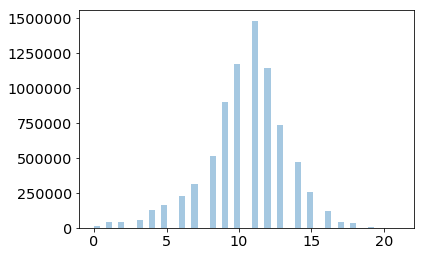

In [14]:
sns.distplot(
    trb_dist[np.triu_indices(trb_dist.shape[0], k=1)], 
    kde=False
)

Look at distance to closest neighbours:

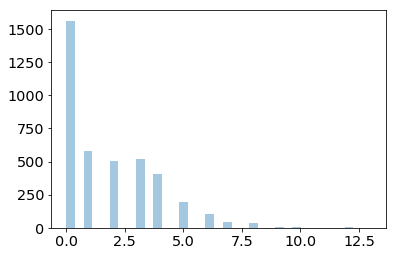

In [15]:
sns_data_nn = pandas.DataFrame({"neighbour0": np.nanmin(trb_dist, axis=1)})
sns.distplot(a=sns_data_nn["neighbour0"].values, kde=False)

In [16]:
sns_data_nn["neighbour0"].value_counts()

0.0     1562
1.0      581
3.0      516
2.0      507
4.0      408
5.0      194
6.0      104
7.0       41
8.0       33
9.0        7
12.0       4
10.0       4
13.0       2
11.0       1
Name: neighbour0, dtype: int64

### Distance metric validation

Look at an example case for validation of the steps above:

In [17]:
d = 1
idx_sample = np.concatenate(np.expand_dims(np.where(trb_dist == d), axis=0), axis=0)
print(vdjdb_trb_clean[idx_sample[0, 0]])
print(vdjdb_trb_clean[idx_sample[1, 0]])

CASSSGQLTNTEAFF
CASSTGQLTNTEAFF


In [18]:
d = 3
idx_sample = np.concatenate(np.expand_dims(np.where(trb_dist == d), axis=0), axis=0)
print(vdjdb_trb_clean[idx_sample[0, 0]])
print(vdjdb_trb_clean[idx_sample[1, 0]])

CSARDRTGNGYTF
CSARDRTGNTIYF


## Define clonotypes

Define clonotypes based on perfect sequence match.

In [19]:
clonotypes = np.zeros([trb_dist.shape[0]], int)
clonotype_counter = 0
for i in range(trb_dist.shape[0]):
    matches = np.where(trb_dist[i, :i] == 0)[0]
    if len(matches) > 0:
        clonotypes[i] = clonotypes[matches[0]]
    else:
        clonotypes[i] = clonotype_counter
        clonotype_counter = clonotype_counter + 1

### Explore size of clonotypes

Compute frequency of each clonotype:

In [20]:
clonotype_freq = pandas.DataFrame({"x": clonotypes})["x"].value_counts().values

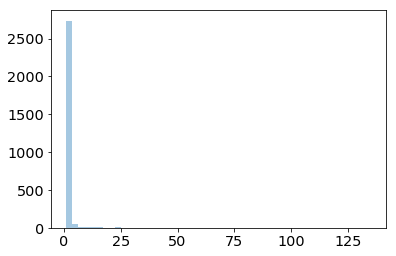

In [21]:
sns.distplot(a=clonotype_freq, kde=False)

Compute the frequency table of clonotype frequencies (information corresponding to the histogram above):

In [22]:
pandas.DataFrame({"x": clonotype_freq})["x"].value_counts().sort_index()

1      2402
2       267
3        66
4        25
5        12
6         8
7         5
8         2
9         3
10        2
11        2
12        2
13        1
14        1
16        1
17        3
19        1
20        1
21        1
23        1
24        1
25        2
28        1
64        1
135       1
Name: x, dtype: int64

In [23]:
print("total number of clonotypes: %i" % len(np.unique(clonotypes)))

total number of clonotypes: 2812


# Data set size if clonotypes are downsampled

In [24]:
def downsample_clono(assignments, max_per_clono):
    clonotypes = np.unique(assignments)
    n_cells = assignments.shape[0]
    idx_to_keep = np.concatenate([np.random.choice(
        a=np.arange(0, n_cells)[assignments == x],
        size=np.min([max_per_clono, np.sum(assignments == x)]),
        replace=False
    ) for x in np.unique(assignments)], axis=0)
    print("data set size downsampled to 10 cells per clonotypes reduces from %i to %i" % (len(assignments), len(idx_to_keep)))
    return len(assignments), len(idx_to_keep)

In [25]:
_ = downsample_clono(assignments=clonotypes, max_per_clono=10)

data set size downsampled to 10 cells per clonotypes reduces from 3964 to 3640


# Explore antigen heterogeneity

In [26]:
antigen_freq = pandas.DataFrame({"x": vdjdb_antigen})["x"].value_counts().values

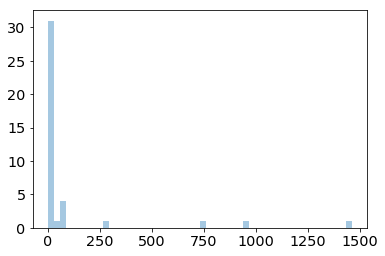

In [27]:
sns.distplot(a=antigen_freq, kde=False)

In [28]:
pandas.DataFrame({"x": antigen_freq})["x"].value_counts().sort_index()

1       11
2        4
3        3
4        1
6        1
7        1
10       2
11       1
12       2
14       2
15       1
19       1
26       1
43       1
61       1
79       1
82       1
85       1
286      1
738      1
941      1
1461     1
Name: x, dtype: int64

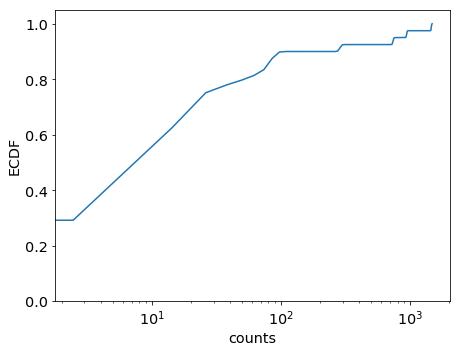

In [29]:
fig, axs = plt.subplots(1, 1, figsize=(6.5, 5))
sns.distplot(
    a=antigen_freq,
    hist=False, kde=True,
    kde_kws=dict(cumulative=True),
    ax=axs
)
axs.set_xscale('log')
axs.set_xlabel('counts')
axs.set_ylabel('ECDF')
fig.tight_layout() 
plt.savefig(figir+"supp_4_c.pdf")
plt.show()

# Explore overlap to IEDB

In [30]:
iedb = pandas.read_csv(datadir+"tcell_receptor_table_export_1558607498.csv").fillna(value="None")
iedb_trb = iedb["Chain 2 CDR3 Curated"].values
iedb_antigen = iedb["Description"].values
idx_to_keep = np.where([x != "None" for x in iedb_trb])[0]
iedb_trb = iedb_trb[idx_to_keep]
iedb_antigen = iedb_antigen[idx_to_keep]

/Users/david.fischer/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (10,12,15,16,17,19,20,21,22,23,24,29,30,35,36,50,51,53,58,59,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Antigens

In [31]:
iedb_antigens_unique = np.unique(iedb_antigen)
vdjdb_antigens_unique = np.unique(vdjdb_antigen)

In [32]:
print("Number of antigens from IEDB in VDJdb: %i out of %i" % 
      (len(set(iedb_antigens_unique).intersection(set(vdjdb_antigens_unique))), len(iedb_antigens_unique)))
print("Number of antigens from VDJdb in IEDB: %i out of %i" % 
      (len(set(iedb_antigens_unique).intersection(set(vdjdb_antigens_unique))), len(vdjdb_antigens_unique)))

Number of antigens from IEDB in VDJdb: 24 out of 71
Number of antigens from VDJdb in IEDB: 24 out of 40


In [33]:
print("Size of VDJdb without overlapping antigens: %i out of %i" % 
      (np.sum([x in set(vdjdb_antigens_unique) - set (iedb_antigens_unique) for x in vdjdb_antigen]), 
      len(vdjdb_antigen)))

Size of VDJdb without overlapping antigens: 116 out of 3964


## TCRs

In [34]:
iedb_trb_unique = np.unique(iedb_trb)
vdjdb_trb_unique = np.unique(vdjdb_trb)

In [35]:
print("Number of TCRs from IEDB in VDJdb: %i out of %i" % 
      (len(set(iedb_trb_unique).intersection(set(vdjdb_trb_unique))), len(iedb_trb_unique)))
print("Number of TCRs from VDJdb in IEDB: %i out of %i" % 
      (len(set(iedb_trb_unique).intersection(set(vdjdb_trb_unique))), len(vdjdb_trb_unique)))

Number of TCRs from IEDB in VDJdb: 1314 out of 10853
Number of TCRs from VDJdb in IEDB: 1314 out of 2812


In [36]:
print("Size of VDJdb without overlapping TCRs: %i out of %i" % 
      (np.sum([x in set(vdjdb_trb_unique) - set (iedb_trb_unique) for x in vdjdb_trb]), 
      len(vdjdb_trb)))

Size of VDJdb without overlapping TCRs: 1831 out of 3964


## Antigens and TCRs

In [37]:
print("Size of VDJdb without overlapping TCRs and antigens: %i out of %i" % 
      (np.sum([x in set(vdjdb_antigens_unique) - set (iedb_antigens_unique) and
               x in set(vdjdb_trb_unique) - set (iedb_trb_unique) 
               for x in vdjdb_trb]), 
      len(vdjdb_trb)))

Size of VDJdb without overlapping TCRs and antigens: 0 out of 3964
